In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [14]:
import os
import sys
import jax
import pandas as pd
import numpy as np
import jax.numpy as jnp
import haiku as hk
import seaborn as sns
import matplotlib.pyplot as plt


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

from src.models.nucleotide_transformer import NucleotideTransformerConfig, build_nucleotide_transformer_fn
from src.models.pretrained import FixedSizeNucleotidesKmersTokenizer
root_dir = '..'

In [3]:
data_fn = 'data/processed/ensemble_mutation_effect_analysis/2023_06_05_164913/tabulated_mutation_info.csv'
data_fn = os.path.join(root_dir, data_fn)

data = pd.read_csv(data_fn)

## Model Definition

In [4]:
def calculate_max_positions(max_seq_length, circuit_size, k_for_kmers, kmer_overlap):
    pad = True
    cls = True
    return int(
        circuit_size * (max_seq_length / (k_for_kmers - kmer_overlap) + 2 * pad + 2 * cls)
    )


hyperparams = {
    'k_for_kmers': 5,
    'max_positions': 32,
    'embed_scale': 1.0,
    'emb_layer_norm_before': False,
    'key_size': 64,
    'attention_heads': 20,
    'embed_dim': 1280,
    'ffn_embed_dim': 5120,
    'num_layers': 24,
    'token_dropout': True,
    'masking_ratio': 0.15,
    'masking_prob': 0.8,
    'use_gradient_checkpointing': False,
}

max_seq_length = data['sample_seq'].apply(len).max()
kmer_overlap = 0
circuit_size = len(data['sample_name'].unique())

tokenizer = FixedSizeNucleotidesKmersTokenizer(
    k_mers=hyperparams["k_for_kmers"],
    fixed_length=calculate_max_positions(max_seq_length, circuit_size, hyperparams["k_for_kmers"], kmer_overlap),
    prepend_cls_token=True,
    append_eos_token=True,
    nucleotide_type='RNA'
)

embeddings_layers_to_save = tuple(np.arange(hyperparams["num_layers"]))
attention_maps_to_save = ((1, 4, 5), (7, 18))  # t[0] is the layer index, rest is attention map
encfg = NucleotideTransformerConfig(
    alphabet_size=len(tokenizer.vocabulary) - 2,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.mask_token_id,
    max_positions=hyperparams['max_positions'],
    embed_scale=hyperparams["embed_scale"],
    # architecture
    emb_layer_norm_before=hyperparams["emb_layer_norm_before"],
    key_size=hyperparams["key_dim"] if "key_dim" in hyperparams.keys() else None,
    attention_heads=hyperparams["attention_heads"],
    embed_dim=hyperparams["embed_dim"],
    ffn_embed_dim=hyperparams["ffn_embed_dim"],
    num_layers=hyperparams["num_layers"],
    # bert
    token_dropout=hyperparams["token_dropout"],
    masking_ratio=hyperparams["masking_ratio"],
    masking_prob=hyperparams["masking_prob"],
    # embeddings to save
    embeddings_layers_to_save=embeddings_layers_to_save,
    attention_maps_to_save=attention_maps_to_save,
)
decfg = NucleotideTransformerConfig(
    alphabet_size=len(tokenizer.vocabulary) - 2,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.mask_token_id,
    max_positions=hyperparams['max_positions'],
    embed_scale=hyperparams["embed_scale"],
    # architecture
    emb_layer_norm_before=hyperparams["emb_layer_norm_before"],
    key_size=hyperparams["key_dim"] if "key_dim" in hyperparams.keys() else None,
    attention_heads=hyperparams["attention_heads"],
    embed_dim=hyperparams["embed_dim"],
    ffn_embed_dim=hyperparams["ffn_embed_dim"],
    num_layers=hyperparams["num_layers"],
    # bert
    token_dropout=hyperparams["token_dropout"],
    masking_ratio=hyperparams["masking_ratio"],
    masking_prob=hyperparams["masking_prob"],
    # embeddings to save
    embeddings_layers_to_save=embeddings_layers_to_save,
    attention_maps_to_save=attention_maps_to_save,
)

forward_fn = build_nucleotide_transformer_fn(encfg)


In [5]:
batch_size = 1000

sequences = data.groupby(['circuit_name', 'mutation_name']).agg({'sample_seq': lambda x: [*x]})['sample_seq'].iloc[:batch_size].to_numpy()
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)


In [6]:
tokens[0]

Array([   3,  755,   39,  380,  712, 1032, 1033,  708,   52,  339,  948,
       1032, 1033,  222,  653,  729,  510, 1033,    1,    1,    1,    1,
          1,    1], dtype=int32)

In [7]:
forward_fnt = hk.transform(forward_fn)
rng = hk.PRNGSequence(jax.random.PRNGKey(42))
params = forward_fnt.init(next(rng), tokens[0, None])

In [8]:
tokens.shape

(1000, 24)

In [9]:
outs = forward_fnt.apply(params, next(rng), tokens[:1000])

In [10]:
outs.keys()

dict_keys(['embeddings_1', 'attention_map_layer_1_number_4', 'attention_map_layer_1_number_5', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'attention_map_layer_7_number_18', 'embeddings_8', 'embeddings_9', 'embeddings_10', 'embeddings_11', 'embeddings_12', 'embeddings_13', 'embeddings_14', 'embeddings_15', 'embeddings_16', 'embeddings_17', 'embeddings_18', 'embeddings_19', 'embeddings_20', 'embeddings_21', 'embeddings_22', 'embeddings_23', 'logits'])

In [11]:
outs['logits'].shape

(1000, 24, 1033)

## Outs

In [12]:
embeddings = outs["embeddings_20"][:, 1:, :]  # removing CLS token
padding_mask = jnp.expand_dims(tokens[:batch_size, 1:] != tokenizer.pad_token_id, axis=-1)
masked_embeddings = embeddings * padding_mask  # multiply by 0 pad tokens embeddings
sequences_lengths = jnp.sum(padding_mask, axis=1)
mean_embeddings = jnp.sum(masked_embeddings, axis=1) / sequences_lengths

logits = outs["logits"]
probabilities = []

# get probabilities separately for each seq as they have different lengths
for seq_id in range(logits.shape[0]):

    logits_seq = logits[seq_id]
    seq_length = int(sequences_lengths[seq_id])
    logits_seq = logits_seq[1 : (seq_length + 1)]  # remove CLS token and pads
    probas = jax.nn.softmax(
        logits_seq, axis=-1
    )  # use softmax to transform logits into probabilities

    probabilities.append(probas)

In [13]:
sequence_id = 0
position_id = 1

probs = probabilities[sequence_id][position_id]
sorted_positions = jnp.argsort(-probs)
sorted_probs = probs[sorted_positions]

top_k = 10
for k in range(top_k):
    predicted_token = tokenizer.id_to_token(int(sorted_positions[k]))
    prob = sorted_probs[k]
    print(f"token: {predicted_token}, probability: {prob * 100:.2f}%")

token: AGAUU, probability: 0.94%
token: GCCUU, probability: 0.89%
token: ACCUC, probability: 0.89%
token: CCUUU, probability: 0.68%
token: CAGUC, probability: 0.58%
token: CUGUA, probability: 0.58%
token: AACGU, probability: 0.53%
token: UUGCC, probability: 0.53%
token: UCUCC, probability: 0.52%
token: GGAUU, probability: 0.52%


In [15]:
outs.keys()

dict_keys(['embeddings_1', 'attention_map_layer_1_number_4', 'attention_map_layer_1_number_5', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'attention_map_layer_7_number_18', 'embeddings_8', 'embeddings_9', 'embeddings_10', 'embeddings_11', 'embeddings_12', 'embeddings_13', 'embeddings_14', 'embeddings_15', 'embeddings_16', 'embeddings_17', 'embeddings_18', 'embeddings_19', 'embeddings_20', 'embeddings_21', 'embeddings_22', 'embeddings_23', 'logits'])

In [17]:
outs['embeddings_1'].shape

(1000, 24, 1280)

<Axes: ylabel='Count'>

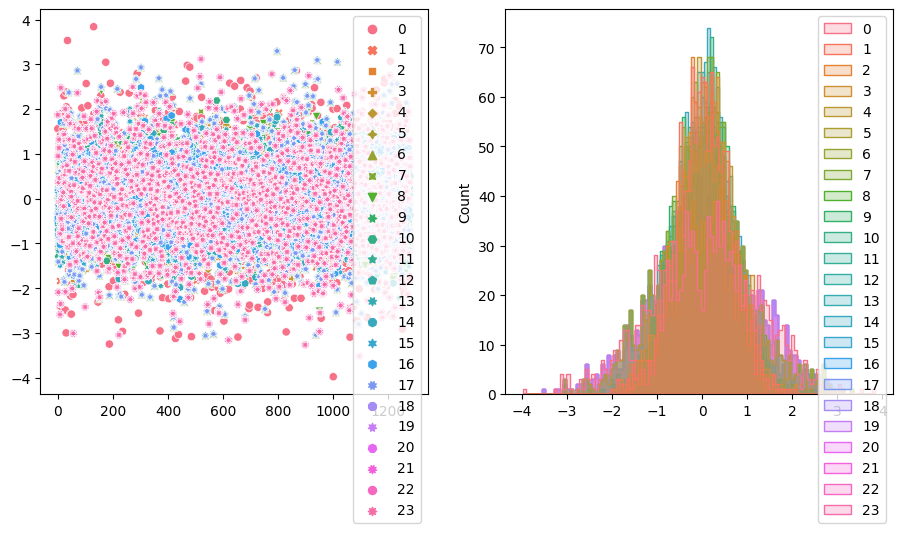

In [16]:
plt.figure(figsize=(11, 5))
ax = plt.subplot(1,2,1)
sns.scatterplot(jnp.average(outs['embeddings_1'], axis=0).T)
ax = plt.subplot(1,2,2)
sns.histplot(jnp.average(outs['embeddings_1'], axis=0).T, element='step')
